# Fusion Model Development


### Classifers to try:

For explainability:
1. Logistic Regression
2. SVM
3. KNN
4. XGBoost

Others to try (based on literature):

1. Lasso
2. ElasticNet

### Results

Choose binary model based on best AUC score - try putting in the fusion model for now

In [13]:
import json

import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset
from torch import nn
import torch.optim as optim
from torchinfo import summary
from torch.nn import functional as F
import tqdm
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, hamming_loss, multilabel_confusion_matrix

from sklearn import svm
from sklearn.model_selection import GridSearchCV 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

import xgboost as xgb

import seaborn as sn
import matplotlib.pyplot as plt

In [14]:
#load data
combined_train_df = pd.read_pickle(r'../data/combined_train_df_wembeddings.pkl')
combined_val_df = pd.read_pickle(r'../data/combined_val_df_wembeddings.pkl')
combined_test_df = pd.read_pickle(r'../data/combined_test_df_wembeddings.pkl')

In [15]:
combined_train_df.columns

Index(['index', 'patient_id', 'visit_id', 'study_id', 'temperature',
       'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity',
       'positive_label_total', 'finding_names', 'radiology_note',
       'discharge_note', 'chief_complaint',
       'major_surgical_or_invasive_procedure', 'history_of_present_illness',
       'past_medical_history', 'family_history', 'atelectasis', 'cardiomegaly',
       'lung_opacity', 'pleural_effusion', 'dataset_type', 'dicom_id',
       'notes_classifications', 'notes_embeddings', 'notes_hidden_embeddings',
       'img_classifications', 'img_embeddings', 'img_densefeatures'],
      dtype='object')

In [16]:
#create aggregated embeddings datasets
#loading datasets
train_x = combined_train_df[['temperature','heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity', 
                             'notes_embeddings', 'notes_hidden_embeddings',
                            'img_embeddings', 'img_densefeatures']]
val_x = combined_val_df[['temperature','heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity', 
                             'notes_embeddings', 'notes_hidden_embeddings',
                            'img_embeddings', 'img_densefeatures']]
test_x = combined_test_df[['temperature','heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity', 
                             'notes_embeddings', 'notes_hidden_embeddings',
                            'img_embeddings', 'img_densefeatures']]

train_y = combined_train_df['finding_names']
val_y = combined_val_df['finding_names']
test_y = combined_test_df['finding_names']

print("TRAIN: shape of x: {}\nshape of y: {}".format(train_x.shape,train_y.shape))
print("VAL: shape of x: {}\nshape of y: {}".format(val_x.shape,val_y.shape))
print("TEST: shape of x: {}\nshape of y: {}".format(test_x.shape,test_y.shape))

TRAIN: shape of x: (2086, 12)
shape of y: (2086,)
VAL: shape of x: (1924, 12)
shape of y: (1924,)
TEST: shape of x: (1920, 12)
shape of y: (1920,)


In [17]:
def reshape_data(data):
    #gets rid of nested embeddings
    flattened_data = pd.DataFrame()
    
    for col in data.columns:
        data[col] = data[col].apply(np.ravel)

        col_names = []
        for i in range(data[col][0].shape[0]):
            col_name = col + str(i)
            col_names.append(col_name)

        flattened_data[col_names] = pd.DataFrame(data[col].tolist(), index= data.index)
    
    return flattened_data

In [18]:
#reshape data
train_x = reshape_data(train_x)
val_x = reshape_data(val_x)
test_x = reshape_data(test_x)

print("TRAIN: shape of x: {}\nshape of y: {}".format(train_x.shape,train_y.shape))
print("VAL: shape of x: {}\nshape of y: {}".format(val_x.shape,val_y.shape))
print("TEST: shape of x: {}\nshape of y: {}".format(test_x.shape,test_y.shape))

TRAIN: shape of x: (2086, 1755)
shape of y: (2086,)
VAL: shape of x: (1924, 1755)
shape of y: (1924,)
TEST: shape of x: (1920, 1755)
shape of y: (1920,)


In [19]:
train_x.head()

,temperature0,heartrate0,resprate0,o2sat0,sbp0,dbp0,pain0,acuity0,notes_embeddings0,notes_embeddings1,...,img_densefeatures1526,img_densefeatures1527,img_densefeatures1528,img_densefeatures1529,img_densefeatures1530,img_densefeatures1531,img_densefeatures1532,img_densefeatures1533,img_densefeatures1534,img_densefeatures1535
0,98.8,106.0,22.0,96.0,93.0,67.0,0,2.0,-0.267226,0.647106,...,0.604024,0.847728,0.235411,0.730207,0.068122,0.857000,0.055642,0.004653,0.111292,0.237230
1,99.1,80.0,16.0,97.0,162.0,67.0,0,3.0,1.196290,0.296975,...,0.636729,0.731136,0.186779,0.619654,0.222132,0.733983,0.154528,0.018952,0.088321,0.213648
2,97.0,98.0,14.0,100.0,159.0,88.0,2,2.0,1.191423,0.430787,...,0.908274,0.968641,0.257039,0.997114,0.093494,1.075215,0.088319,0.007294,0.080976,0.213116
3,98.6,92.0,20.0,98.0,127.0,70.0,0,2.0,0.443146,1.201157,...,0.980167,1.070965,0.229824,0.877981,0.058277,1.270879,0.053015,0.012560,0.166239,0.218688
4,100.6,110.0,16.0,97.0,166.0,100.0,8,2.0,0.673903,1.203965,...,0.857741,0.895503,0.378214,0.444787,0.078207,0.910277,0.102543,0.052296,0.186534,0.183555


In [29]:
#recode y classes as integers
target_variables_dict = {
    'no_finding': 0,
    'atelectasis': 1,
    'cardiomegaly': 2,
    'lung_opacity': 3,
    'pleural_effusion': 4,
}

def recode_features(data):
    data = data.replace("no_finding", 0)
    data = data.replace("atelectasis", 1)
    data = data.replace("cardiomegaly", 2)
    data = data.replace("lung_opacity", 3)
    data = data.replace("pleural_effusion", 4)
    return data

train_y = recode_features(train_y)
val_y = recode_features(val_y)
test_y = recode_features(test_y)

C:\Users\Carolyn\AppData\Local\Temp\ipykernel_18452\1719064654.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace("pleural_effusion", 4)


In [30]:
#feature scaling
sc = StandardScaler()

train_x = sc.fit_transform(train_x)
val_x = sc.fit_transform(val_x)
test_x = sc.fit_transform(test_x)

In [31]:
#adjust parameters
BATCH_SIZE = 64
LEARNING_RATE = 0.01
EPOCHS = 1000

In [32]:
#defining dataset class
class dataset(Dataset):
  def __init__(self,x,y):
    self.x = torch.tensor(x,dtype=torch.float32)
    self.y = torch.tensor(y,dtype=torch.float32)
    self.length = self.x.shape[0]
 
  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]
  def __len__(self):
    return self.length
      
trainset = dataset(train_x,train_y)

#DataLoader
trainloader = DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=False)

In [33]:
#without Dataloader
X_train = torch.from_numpy(train_x).float()
X_val = torch.from_numpy(val_x).float()

y_train = torch.from_numpy(train_y.to_numpy()).float().reshape(len(train_y), 1)
y_val = torch.from_numpy(val_y.to_numpy()).float().reshape(len(val_y), 1)

## Logistic Regression

In [45]:
# build custom module for logistic regression
class LogisticRegression(nn.Module): 
    def __init__(self, input_size, num_classes): 
        super(LogisticRegression, self).__init__() 
        self.linear = nn.Linear(input_size, num_classes) 
  
    def forward(self, x): 
        out = self.linear(x) 
        out = nn.functional.softmax(out, dim=1) 
        return out 

In [46]:
# Model , Optimizer, Loss
model = LogisticRegression(input_size=train_x.shape[1], num_classes=5)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
loss_function = nn.CrossEntropyLoss() 

In [52]:
# Check for cuda 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
# Move the model to the device 
model = model.to(device)
summary(model, input_size=train_x.shape)

Layer (type:depth-idx)                   Output Shape              Param #
LogisticRegression                       [2086, 5]                 --
├─Linear: 1-1                            [2086, 5]                 8,780
Total params: 8,780
Trainable params: 8,780
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 18.32
Input size (MB): 14.64
Forward/backward pass size (MB): 0.08
Params size (MB): 0.04
Estimated Total Size (MB): 14.76

In [53]:
def calculate_accuracy(preds, actuals):
    
    with torch.no_grad():
        rounded_preds = torch.round(preds)
        num_correct = torch.sum(rounded_preds == actuals)
        accuracy = num_correct/len(preds)
        
    return accuracy

In [54]:
# Train the model 
for epoch in range(EPOCHS): 
    for i, (inputs, labels) in enumerate(trainloader): 
        # Move inputs and labels to the device 
        inputs = inputs.to(device) 
        labels = labels.to(device) 
  
        # Forward pass 
        outputs = model(inputs) 
        loss = loss_function(outputs, labels) 
  
        # Backward and optimize 
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 
  
    # Print training loss for each epoch 
    if (epoch+1)%100 == 0: 
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

RuntimeError: expected scalar type Long but found Float

In [ ]:
plt.figure(figsize=(10,6))
plt.grid()
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train_losses', 'test_losses'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

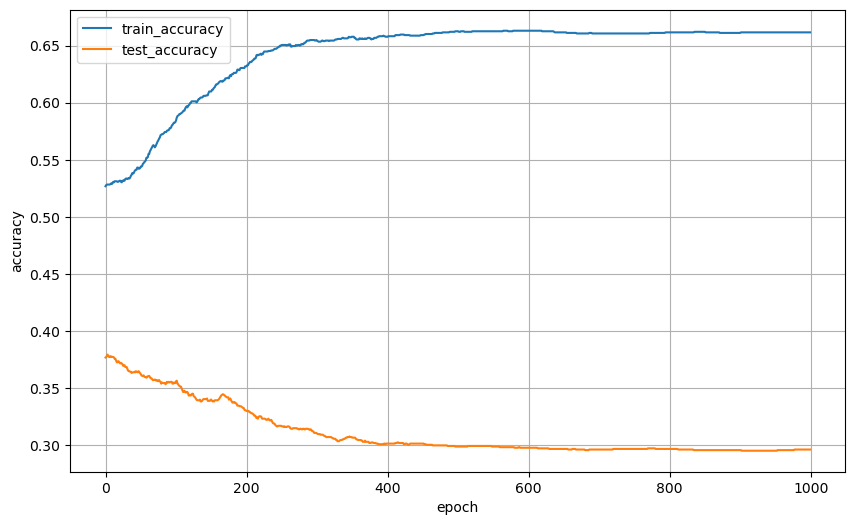

In [17]:
plt.figure(figsize=(10,6))
plt.grid()
plt.plot(train_accs)
plt.plot(test_accs)
plt.legend(['train_accuracy', 'test_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

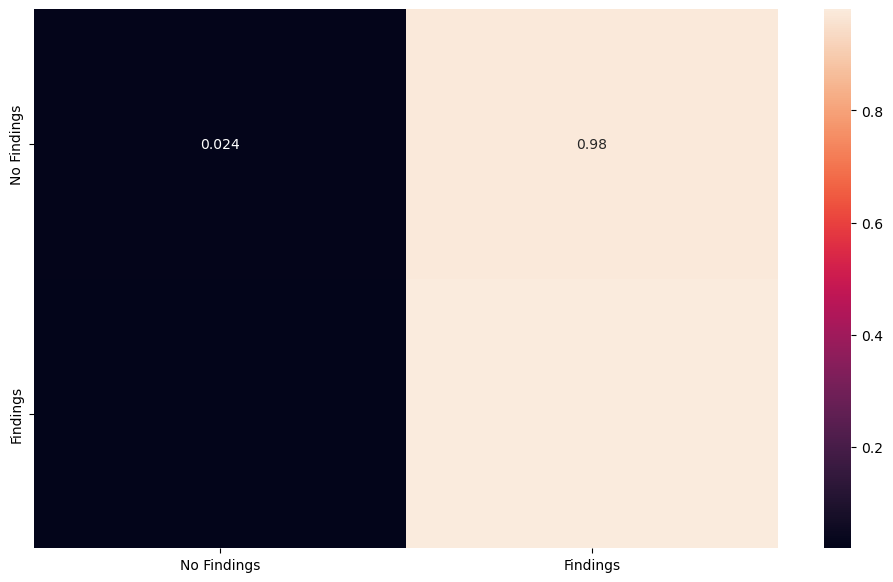

In [18]:
# constant for classes
classes = ('No Findings', 'Findings')

# Build confusion matrix
cf_matrix = confusion_matrix(y_val, test_preds.round())
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

## SVM

In [55]:
#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train.ravel())

#Predict the response for test dataset
y_pred = clf.predict(X_val)

In [56]:
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",accuracy_score(y_val, y_pred))

Accuracy: 0.5337837837837838


In [ ]:
print("AUC:",roc_auc_score(y_val, y_pred))

In [57]:
# defining parameter range 
param_grid = {'C': [0.1, 1, 10],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf', 'linear']}  
  
grid = GridSearchCV(clf, param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train.ravel()) 

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.337 total time=   5.2s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.336 total time=   4.9s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.336 total time=   4.9s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.338 total time=   5.6s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.338 total time=   5.3s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.897 total time=   0.6s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.911 total time=   0.6s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.911 total time=   0.5s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.882 total time=   0.6s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.904 total time=   0.6s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.337 total time=   4.6s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf

GridSearchCV(estimator=SVC(kernel='linear'),
             param_grid={'C': [0.1, 1, 10],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear']},
             verbose=3)

In [58]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
SVC(C=1, gamma=0.001)


In [59]:
grid_predictions = grid.predict(X_val) 
  
# print classification report 
print(classification_report(y_val, grid_predictions)) 

              precision    recall  f1-score   support

         0.0       0.86      0.63      0.73      1376
         1.0       0.12      0.21      0.15       117
         2.0       0.30      0.45      0.36       128
         3.0       0.28      0.46      0.35       219
         4.0       0.22      0.45      0.30        84

    accuracy                           0.56      1924
   macro avg       0.36      0.44      0.38      1924
weighted avg       0.68      0.56      0.61      1924



In [60]:
confusion_matrix(y_val, grid_predictions)

array([[867, 137, 102, 190,  80],
       [ 48,  24,  18,  22,   5],
       [ 29,  12,  57,  16,  14],
       [ 55,  22,   9, 100,  33],
       [ 14,   5,   2,  25,  38]], dtype=int64)

## KNN

In [61]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

C:\Users\Carolyn\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [62]:
y_pred = knn.predict(X_val)

In [ ]:
auc = roc_auc_score(y_val, y_pred)
print("AUC:", auc)

In [64]:
k_values = [i for i in range (1,31)]
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train, y_train.ravel(), cv=5)
    scores.append(np.mean(score))

C:\Users\Carolyn\anaconda3\envs\pytorch_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Carolyn\anaconda3\envs\pytorch_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Accuracy Score')

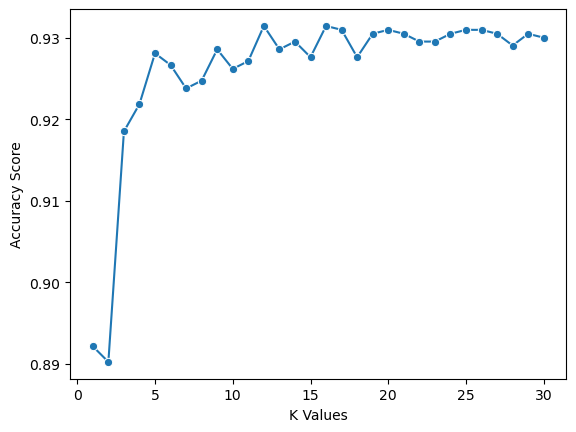

In [65]:
sn.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [68]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_val)
auc = roc_auc_score(y_val, y_pred, multi_class='ovr')
print("AUC:", auc)
print(confusion_matrix(y_val, y_pred))

C:\Users\Carolyn\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


AxisError: axis 1 is out of bounds for array of dimension 1

In [69]:
# XGBoost

In [70]:
# XGBoost (different learning rate)
learning_rate_range = np.arange(0.01, 1, 0.05)
test_XG = [] 
train_XG = []
for lr in learning_rate_range:
    xgb_classifier = xgb.XGBClassifier(eta = lr)
    xgb_classifier.fit(X_train, y_train.ravel())
    train_XG.append(xgb_classifier.score(X_train, y_train.ravel()))
    test_XG.append(xgb_classifier.score(X_val, y_val.ravel()))

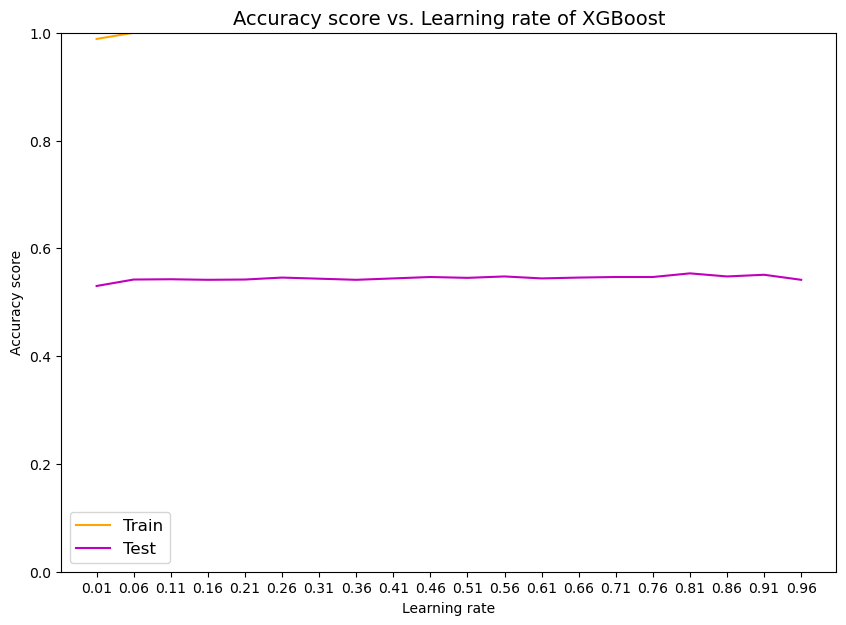

In [71]:
fig = plt.figure(figsize=(10, 7))
plt.plot(learning_rate_range, train_XG, c='orange', label='Train')
plt.plot(learning_rate_range, test_XG, c='m', label='Test')
plt.xlabel('Learning rate')
plt.xticks(learning_rate_range)
plt.ylabel('Accuracy score')
plt.ylim(0, 1)
plt.legend(prop={'size': 12}, loc=3)
plt.title('Accuracy score vs. Learning rate of XGBoost', size=14)
plt.show()

# Summary

KNN n=2 performed the best - compare with multilabel and decide if worth using in fusion context!